iter:2500 training loss: 2.700565346458461e-05, val loss: 2.9024984542047605e-05
iter:5000 training loss: 3.4946649975609034e-05, val loss: 1.5022637853689957e-05
iter:7500 training loss: 2.7382036932976916e-05, val loss: 2.186725578212645e-05
iter:10000 training loss: 3.202314110239968e-05, val loss: 3.0008177418494597e-05
iter:12500 training loss: 2.5358731363667175e-05, val loss: 2.3136750314733945e-05
iter:15000 training loss: 2.7438163670012727e-05, val loss: 2.368159039178863e-05
iter:17500 training loss: 3.2430838473374024e-05, val loss: 2.0218258214299567e-05
iter:20000 training loss: 2.541259709687438e-05, val loss: 3.3926578907994553e-05
iter:22500 training loss: 3.019464566023089e-05, val loss: 2.9463733881129883e-05
iter:25000 training loss: 2.0521378246485256e-05, val loss: 3.277532960055396e-05
iter:27500 training loss: 3.297251168987714e-05, val loss: 1.9407380023039877e-05
iter:30000 training loss: 3.4210468584205955e-05, val loss: 2.9374274163274094e-05
iter:32500 trai

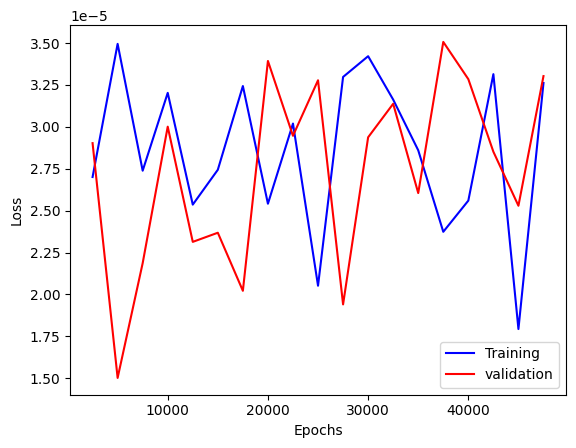

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    ## Create colormap (red to blue)
    colormap = 'RdBu_r'
    # Plot the matrix
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1)
    fig.show()
    fig.data = ()

input_size = 10
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.01
max_iters = 50000
dataset_size = 1024
sparsity = 0.01 # appears only one in 100 times
batch_size = 32

decay_factor = 0.9
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.5**i for i in range(input_size)])


def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    # TODO Implement mini batch
    a,b = training_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = training_dataset*sparsity_mat
    return X, X

def sample_validation_data():
    a,b = validation_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = validation_dataset*sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_layer_size, bias= False)
        self.layer2 = nn.Linear(hidden_layer_size, output_size)
        self.relu = torch.nn.functional.gelu
    
    def forward(self, input, targets = None):
         # Input is (B,I)
        logits = self.layer1(input) # (B, dim)
        logits = self.relu(logits)
        logits = self.layer2(logits)

        # layer_1_weight = self.layer1.weight.data # (dim, I)
        # logits = logits @ layer_1_weight # (B, dim) * (dim, I) -> (B,I)
        # logits += self.layer2.bias
        
        
        if targets is None:
            return logits
        else:
            loss = get_loss(targets, logits)
            return logits, loss

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()

LOAD_MODEL = False
PATH = "models/basic_relu_0.10.bin"
if LOAD_MODEL:
    model = Model()
    model.load_state_dict(torch.load(PATH))
    model.eval()
else:
    optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
    start_time = time.time()
    step_value = max_iters/20
    for i in range(1, max_iters):
        X, Y = sample_data()
        logits, loss = model(X, Y)
    
        if i%step_value ==0 :
            model.eval()
            with torch.no_grad():
                X_V,Y_V = sample_validation_data()
                _, val_loss = model(X_V, Y_V)
                iters.append(i)
                loss_value.append(loss.item())
                val_loss_value.append(val_loss.item())
                print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
            model.train()

        optimizer.zero_grad(set_to_none=True)
        #loss+= get_l1_penalty()
        loss.backward()
        optimizer.step()


    end_time = time.time()
    print(f"Took {end_time-start_time}s for {max_iters} epochs")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(iters,loss_value, color='blue', label="Training")
    plt.plot(iters, val_loss_value, "red", label = "validation")
    plt.legend()
    plt.show()




In [37]:


w1 = model.layer1.weight
w2 = model.layer2.weight
b1 = model.layer1.bias

b2 = model.layer2.bias
# visualise_tensor(torch.transpose(w1,0,1)@w1)
visualise_tensor(torch.transpose(w1,0,1))
visualise_tensor(torch.transpose(w2,0,1))
visualise_tensor(w2@w1)
visualise_tensor(b2.data.reshape(-1,1))

In [17]:
# Norm of embedding
norm = [0 for i in range(input_size)]
for i in range(input_size):
    idx = torch.zeros(input_size)
    idx[i] = 1
    idx = w1@idx
    norm[i] = idx.norm()
norm = torch.tensor(norm)
visualise_tensor(norm.reshape(-1,1))


# Interference
dot = [0 for i in range(input_size)]
for i in range(input_size):
    s = 0
    embed_a = w1[:,i]
    for j in range(input_size):
        if i==j:
            continue
        embed_b = w1[:,j]
        s+= (torch.dot(embed_a,embed_b))**2
    
    dot[i] = s

dot = torch.tensor(dot)
print(dot)
visualise_tensor(dot.reshape(-1,1))


tensor([1.6796e-04, 8.5343e-05, 1.5244e-04, 7.9644e-01, 7.2177e-01, 7.9606e-01,
        7.2154e-01, 2.2512e-04, 4.7869e-05, 1.9304e-04, 5.7382e-05, 1.0149e-04,
        7.0350e-05, 7.5472e-05, 2.8007e-04, 9.3697e-05, 1.9666e-04, 1.7844e-05,
        1.9963e-04, 2.2957e-04])


In [62]:
PATH = "../models/basic_relu_0.03.bin"
torch.save(model.state_dict(), PATH)
